# Factor Analysis
Factor analysis is another **latent variable model**. Unlike the previous notebook on mixture models, which assume that each datapoint comes from one of several discrete latent categories to produce a set of clusters, factor analysis instead assumes that datapoints are generated by a small number of continuous latent factors ($K<<D$) that linearly combine to explain correlations in the observed data, with some additional noise.

In [915]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

rng = np.random.default_rng(10)
np.random.seed(10)

We've just said that factor analysis assumes that data is generated as a **linear combination of unobserved factors**. 

Consider a student who performs well across several subjects, like maths, physics, and history. Their performance could be explained by a few underlying traits such as problem-solving ability or memory. Each student's observed scores are then a different mixture of these hidden factors. 

The factors are described by a loadings matrix, $W$, which maps the latent factors into the observed space, indicating how much each hidden factor influences the observed variables. In the below graph, $$W=\begin{bmatrix}1.5&0.4\\1.0&1.5\end{bmatrix}$$

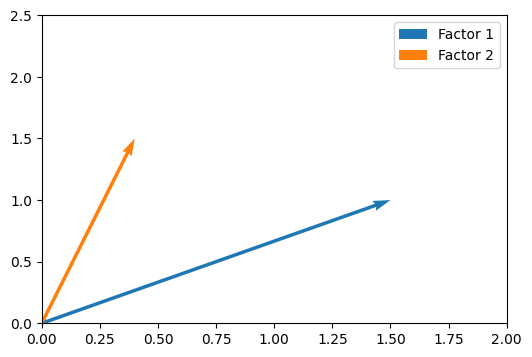

In [916]:
def draw_arrows(W, x=0, y=0):
    fig, ax = plt.subplots(figsize=(6,4))

    ax.scatter(x,y)

    colours = ["C0", "C1"]
    labels = ["Factor 1", "Factor 2"]
    for k in range(W.shape[1]):
        ax.quiver(x, y, W[0, k], W[1, k],
                scale=1, 
                angles="xy", 
                scale_units="xy",
                color=colours[k],
                label=labels[k])
        
    return ax

W  = np.array([
    [1.5, 0.4],
    [1.0, 1.5]
])

ax = draw_arrows(W)
ax.set_xlim(0,2.0)
ax.set_ylim(0,2.5)

plt.legend()
plt.show()

We can generate synthetic observations by combining factors with different weights, $z$. 

In the below graph, we've generated new datapoints as some linear combinations of *Factor 1* and *Factor 2* by hand-picking values of $z$. Each new datapoint is given as a weighted combination of the underlying factors: $$x=z_1 W_{\cdot1} + z_{2} W_{\cdot2}$$

If *Factor 1* represented intelligence, and *Factor 2* represented general problem-solving ability, then the new datapoints could represent something like test scores.

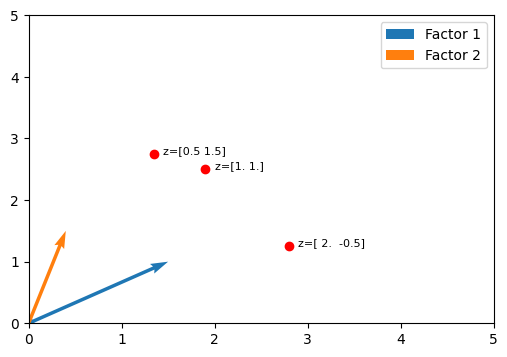

In [917]:
ax = draw_arrows(W)
    
Z = np.array([
    [1, 1],
    [2, -0.5],
    [0.5, 1.5]
])

X = Z @ W.T

ax.scatter(X[:,0], X[:,1], c="red")

for i, (x, y) in enumerate(X):
    ax.text(x + 0.10, y, f"z={Z[i]}", fontsize=8)

ax.set_xlim(0,5)
ax.set_ylim(0,5)
plt.legend()
plt.show()

In practice, we don't hand-define $z$ for every single datapoint - we draw it from a **Gaussian distribution**. This makes sense: many traits in the real world are normally distributed (such as memory, problem-solving ability); and using a Gaussian offers mathematical convenience. 

This means that a given datapoint, $x$, is given by:
$$x=Wz, \quad z\sim(0,I)$$

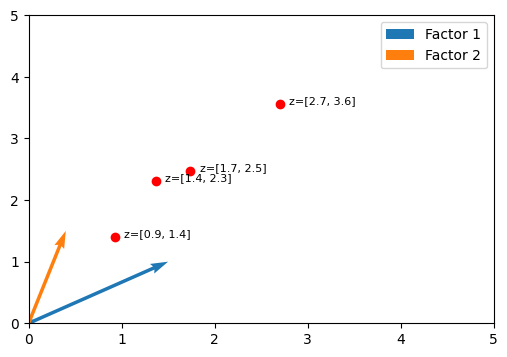

In [918]:
ax = draw_arrows(W)
    
Z = rng.normal(loc=1, scale=0.5, size=(4, 2))

X = Z @ W.T

ax.scatter(X[:,0], X[:,1], c="red")

for i, (x, y) in enumerate(X):
    ax.text(x + 0.10, y, f"z=[{X[i,0]:.1f}, {X[i,1]:.1f}]", fontsize=8)

ax.set_xlim(0,5)
ax.set_ylim(0,5)
plt.legend()
plt.show()

Let's look at some real world data. The dataset shows the height and weight of 10,000 18-year-olds. 

We can plainly see that they're highly correlated. Factor analysis assumes that there is some unobserved latent factor that drives this correlation. For illustration, we can choose a loading vector $W$ that roughly aligns with the shape of the data cloud:
$$W=\begin{bmatrix}25\\3\end{bmatrix}$$

For illustrative purposes, we plot the vector of the latent factor and reposition it into the data space (this is the role of the empirical mean, $\mu$, in factor analysis - translation into the data space), then scale it to stretch across the cloud. The intuition is that each datapoint is generated as a linear combination of the latent factor (stretching along the blue vector, according to a normal distribution) plus noise (jittering off the line). This is the essence of factor analysis: we want to discover the vectors $W$ that explain shared variation, and then generate new datapoints as linear combinations ($z$) of those vectors, shifted into the data space via addition of the mean ($\mu$), plus noise ($\epsilon$):
$$x=\mu+Wz+\epsilon, \quad z\sim\mathcal{N}(0,I), \epsilon\sim\mathcal{N}(0, \Psi)$$
where $\Psi$ is the noise covariance, often assumed to be diagonal in factor analysis (i.e., each variable has its own idiosyncratic variance).

Text(0, 0.5, 'Height (inches)')

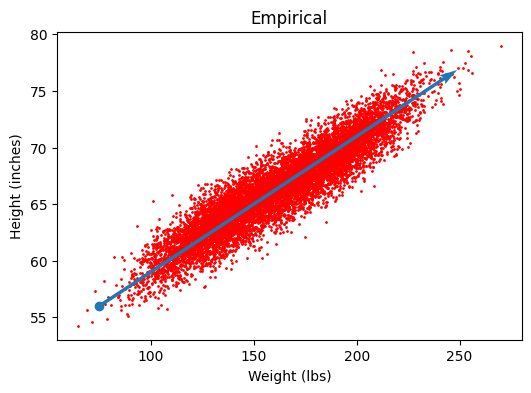

In [919]:
data = pd.read_csv("./datasets/weight-height.csv")

W = np.array([
    [25],
    [3]
])
W = W / np.linalg.norm(W) * 175

ax = draw_arrows(W, 75, 56)
plt.scatter(data["Weight"], data["Height"], c='red', s=1, zorder=0)
plt.title("Empirical")
plt.xlabel("Weight (lbs)")
plt.ylabel("Height (inches)")

Let's see how we can do that to generate synthetic data samples from the real data distribution.


In [920]:
X = data[["Weight", "Height"]].to_numpy()
n=10000

We proceed as follows:
1. Take the empirical mean of the data, $\mu$.
2. Hand-engineer the noise covariance matrix, $\Psi$.
3. Sample $z$ from a unit Gaussian distribution, $z\sim\mathcal{N}(0,I)$.
4. Sample $\epsilon$ from a Gaussian distribution parameterised by $\Psi$ and centered at zero, $\epsilon\sim\mathcal{N}(0, \Psi)$.
4. Generate new samples according to: $x=\mu+Wz+\epsilon$


Text(0, 0.5, 'Height (inches)')

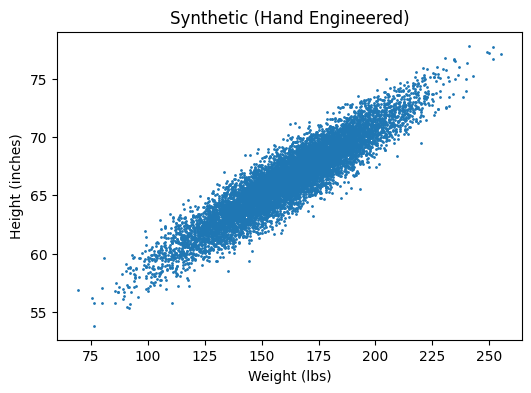

In [921]:
W = np.array([
    [25],
    [3]
])

# Take the empirical mean
mu = X.mean(0)

# Generate the noise covariance matrix, Psi
psi = np.diag(np.array([1.5,1.5]))

# Sample z from a unit Gaussian
z = np.random.normal(size=(n, 1))

# Sample epsilon from a Gaussian with mean 0 and covariance Psi
epsilon = np.random.multivariate_normal(mean=[0,0], cov=psi, size=n)

# Generate samples according to x=mu+Wz+epsilon
samples = mu + z @ W.T + epsilon

plt.figure(figsize=(6,4))
plt.scatter(samples[:,0], samples[:,1], s=1)
plt.title("Synthetic (Hand Engineered)")
plt.xlabel("Weight (lbs)")
plt.ylabel("Height (inches)")

That looks like a fairly good representation of our empirical distribution. However, real datasets are rarely that cooperative. They're higher dimensional, exhibit only moderate correlations, and may require multiple latent factors to explain shared variation. Hand-engineering solutions is not feasible. 

We can instead fit the parameters, $W$ and $\Psi$, via the **Expectation Maximisation (EM)** algorithm, similar to the one we saw for fitting GMMs in the previous notebook, and requires maximising the **log-likelihood**. The log-likelihood of the data involves marginalising over the latent factors:
$$l(\theta)=\sum_{i=1}^N\log\int p(x, z | \theta) dz_i$$

Because we can't directly observe $z$, we instead take their *expected values*, $\mathbb{E}_\theta(z|x)$, given what we do see - i.e., the data $x$, and the parameters $\theta$. We then use those expected values to re-estimate $\theta$ in a way that increases the expected log-likelihood.

The log-likelihood, given access to complete data, is calculated by:
$$
\begin{align}
\log p(x, z|\theta)&=\log p(x|z, \theta) + \log p(z_i) \\
&=\log \mathcal{N}(\mu+Wz, \Psi) + \log \mathcal{N}(0,I)\\
&= -\frac{1}{2}(x-\mu-Wz)^\intercal\Psi^{-1}(x-\mu-Wz)-\frac{1}{2}z^\intercal z - \frac{1}{2}\log|\Psi|+c
\end{align}$$
Note the term $z^\intercal z$ - this means that $\log p(x, z|\theta)$ is quadratic in $z$. Therefore, its expectation depends only on $\mathbb{E}[z|x]$ and $\mathbb{E}[zz^\intercal|x]$ - this also means that we'll have to derive the conditional distribution $p(z|x)$. To do that, we'll first have to derive $p(x)$.

Let's re-visit the equation we saw earlier:
$$x=\mu+Wz+\epsilon, \quad z\sim\mathcal{N}(0,I), \epsilon\sim\mathcal{N}(0, \Psi)$$
We're saying that we first draw a latent $z$, and then draw $x$ given $z$ - i.e., $x$ is conditional on $z$. We can rewrite the above as:
$$z\sim\mathcal{N}(0, I), \quad x|z\sim\mathcal{N}(\mu+Wz, \Psi)$$


This means that if we know $z$, the distribution of $x$ is Gaussian with mean $\mu+Wz$ and covariance $\Psi$, i.e.:
$$\mathbb{E}[x|z]=\mu+Wz, \quad \text{Cov}(x|z)=\Psi$$
Because we don't know $z$, we need to integrate over it to obtain the marginal distribution of $x$ (i.e., the distribution irrespective of $z$): $$p(x)=\int p(x|z)\cdot p(z) dz$$

Instead of doing this integral directly, we can directly calculate the mean and covariance of the marginal distribution.


#### The Marginal Mean
Using the law of total expectation:
$$\mathbb{E}[x]=\mathbb{E}[\mathbb{E}[x|z]]$$
We know that $\mathbb{E}[x|z]=\mu+Wz$ (see above), so we can then say:
$$
\begin{align}
\mathbb{E}[x]&=\mathbb{E}[\mu+Wz]\\&=\mathbb{E}[\mu]+\mathbb{E}[Wz]\\&=\mu+W\mathbb{E}[z]
\end{align}$$
(note that $\mathbb{E}[\mu+Wz]=\mu+W\mathbb{E}[z]$ because $\mu$ and $W$ are constants, and the expectation of a constant is the constant itself).

We also know that because $z\sim\mathcal{N}(0, I)$, $\mathbb{E}[z]=0$. 

Therefore, $\mathbb{E}[x]=\mu$.

#### The Marginal Covariance
To calculate the marginal covariance we take a similar approach. Using the law of total covariance:
$$\text{Cov}(x)=\mathbb{E}[\text{Cov}(x|z)]+\text{Cov}(\mathbb{E}[x|z])$$

For the first term, recall that $x|z\sim\mathcal{N}(\mu+Wz, \Psi)$ - the covariance of this distribution is $\Psi$, hence $\text{Cov}(x|z)=\Psi$ and so $\mathbb{E}[\text{Cov}(x|z)]=\mathbb{E}[\Psi]=\Psi$.

For the second term, recall that $\mathbb{E}[x|z]=\mu+Wz$. Because constants don't affect covariance, we know that $\text{Cov}(\mu+Wz)=\text{Cov}(Wz)$.

We can also use the fact that the covariance of a linear transformation (i.e., $W$) follows the rule:
$$\text{Cov}(Ay)=A \text{Cov}(y)A^\intercal$$
Therefore, we can pull out $W$ from $\text{Cov}(\mu+Wz)=\text{Cov}(Wz)$ as:
$$\text{Cov}(Wz)=W\text{Cov}(z)W^\intercal$$
We also know that $z$ is sampled from a unit Gaussian, $z\sim\mathcal{N}(0, I)$, so $\text{Cov}(z)=I$. 

Therefore: 
$$\text{Cov}(\mu+Wz)=W I W^\intercal=WW^\intercal$$

Finally, revisiting the law of total covariance, we can combine our two results to yield:
$$\text{Cov}(x)=\Psi + WW^\intercal$$

#### Defining the Marginal Distribution
Finally, using the marginal mean and covariance, we can define the marginal distribution of $x$:
$$x\sim\mathcal{N}(\mu, WW^\intercal + \Psi)$$
This is the distribution that Factor Analysis assumes data is drawn from. (i.e., the entire dataset is drawn from a single multivariate Gaussian distribution).  

#### Defining the Conditional Distribution
Now that we have the marginal distribution, $p(x)$, we can start to derive the conditional distribution $p(z|x)$:
$$\begin{bmatrix}z \\ x \end{bmatrix} \sim \mathcal{N} \left(\begin{bmatrix}\mu_z \\ \mu_x \end{bmatrix}, \begin{bmatrix}\text{Cov}(z) & \text{Cov}(z,x) \\ \text{Cov}(x,z) & \text{Cov}(x)\end{bmatrix}\right)$$

Substituting our values in from earlier:
$$\begin{bmatrix}z \\ x \end{bmatrix} \sim \mathcal{N} \left(\begin{bmatrix}0 \\ \mu \end{bmatrix}, \begin{bmatrix}I & W^\intercal \\ W & WW^\intercal+\Psi\end{bmatrix}\right)$$

We can then use the Gaussian conditioning identity:
$$\begin{bmatrix}a \\ b \end{bmatrix} \sim \mathcal{N} \left(\begin{bmatrix}\mu_a \\ \mu_b \end{bmatrix}, \begin{bmatrix}\Sigma_{aa} & \Sigma_{ab} \\ \Sigma_{ba} & \Sigma_{bb}\end{bmatrix}\right),$$
$$a|b\sim \mathcal{N}\left(\mu_a + \Sigma_{ab}\Sigma^{-1}_{bb}(b-\mu_b), \Sigma_{aa}-\Sigma_{ab}\Sigma^{-1}_{bb}\Sigma_{ba}\right)$$

By substituting in our values, we can yield our posterior mean (this comes from the $\mathcal{N}$ parameter above):
$$
\begin{align}
\mathbb{E}[z|x]&=\mu_a + \Sigma_{ab}\Sigma^{-1}_{bb}(b-\mu_b)\\
&=0+W^\intercal(WW^\intercal+\Psi)^{-1}(x-\mu)
\end{align}$$

And posterior covariance:
$$
\begin{align}
\text{Cov}(z|x)&=\Sigma_{aa}-\Sigma_{ab}\Sigma^{-1}_{bb}\Sigma_{ba}\\
&=I-W^\intercal(WW^\intercal+\Psi)^{-1}W
\end{align}$$

Applying the Woodbury matrix identity to $(WW^\intercal + \Psi)^{-1}$, we can rewrite:
$$\mathbb{E}[z|x]=GW^\intercal\Psi^{-1}(x-\mu), \quad \text{Cov}(z|x)=G$$
where $G=(I+W^\intercal\Psi^{-1}W)^{-1}$.

This yields the first moment: $$\mathbb{E}[z|x]=GW^\intercal\Psi^{-1}(x-\mu)$$

From which we can derive the second moment:
 $$\mathbb{E}[zz^\intercal|x]=G+\mathbb{E}[z|x]\cdot\mathbb{E}[z|x]^\intercal$$

## The EM Algorithm

#### E-Step
We want to calculate the **expected** complete-data log-likelihood summed over the posterior of each latent variable:
$$\sum_{i=1}^N\mathbb{E}_{p(z_i|x_i, \theta)}\left[\log p(x_i, z_i|\theta\right)]$$

(recall that $\log p(x_i, z_i|\theta)=-\frac{1}{2}(x-\mu-Wz)^\intercal\Psi^{-1}(x-\mu-Wz)-\frac{1}{2}z^\intercal z - \frac{1}{2}\log|\Psi|+c$).

We can substitute $z$ for $\mathbb{E}[z|x]$ and $zz^\intercal$ for $\mathbb{E}[zz^\intercal|x]$ (remember we said we'd use expectations instead of actual values). To do so, we sum over  datapoints and collect the averages (sample covariance, $S$):
$$
\begin{align}
S_{xx}&=\frac{1}{N}\sum_{i=1}^N x_i\cdot x_i^\intercal \\
S_{xz}&=\frac{1}{N}\sum_{i=1}^N x_i \cdot \mathbb{E}[z_i|x_i]^\intercal \\
S_{zz}&=\frac{1}{N}\sum_{i=1}^N \mathbb{E}[z_iz_i^\intercal|x_i]
\end{align}$$

#### M-Step
We update the factors, $W$, according to:
$$W=S_{xz}\cdot S_{zz}^{-1}$$

We update the noise covariance matrix, $\Psi$, according to: 
$$\Psi=\text{diag}(S_{xx}-WS_{xz}^\intercal)$$

## E-Step
$$\begin{align}
S_{xx}&=\frac{1}{N}\sum_{i=1}^N x_i\cdot x_i^\intercal \\
S_{xz}&=\frac{1}{N}\sum_{i=1}^N x_i \cdot \mathbb{E}[z_i|x_i]^\intercal \\
S_{zz}&=\frac{1}{N}\sum_{i=1}^N \mathbb{E}[z_iz_i^\intercal|x_i]
\end{align}$$
We can rewrite the above in vectorised form, where $X\in\mathbb{R}^{N\times D}$ and each row is a datapoint $x_i^\intercal$, and $Z\in\mathbb{R}^{N\times K}$ where each row is the posterior mean $\mathbb{E}[z_i|x_i]^\intercal$:
$$
\begin{align}
S_{xx}=\frac{1}{N}X^\intercal X \in \mathbb{R}^{D\times D} \\
S_{xz}=\frac{1}{N}X^\intercal Z \in \mathbb{R}^{D\times K} \\
S_{zz}=G + \frac{1}{N}Z^\intercal Z \in \mathbb{R}^{K\times K}
\end{align}$$
where $G=(I+W^\intercal\Psi^{-1}W)^{-1}$ (note that $G$ is equal for all datapoints, so we can moving it outside of the bracket is equivalent without additional computation).

In [922]:
def e_step(X, Z, G):
    N, _ = X.shape

    Sxx = (X.T @ X) / N
    Sxz = (X.T @ Z) / N
    Szz = G + ((Z.T @ Z) / N)

    return Sxx, Sxz, Szz

## M-Step
$$W=S_{xz}\cdot S_{zz}^{-1}$$

$$\Psi=\text{diag}(S_{xx}-WS_{xz}^\intercal)$$

In [923]:
def m_step(Sxx, Sxz, Szz):
    W = Sxz @ np.linalg.inv(Szz)

    Psi = np.diag(Sxx - (W @ Sxz.T))

    return W, Psi

We can then write a function to fit the FA model. We'll need to initialise $\Psi$ and $W$ and centre our $X$ data. Then, we also need calculate $G$ and $Z$ ($Z\in\mathbb{R}^{N\times K}$ each row is $\mathbb{E}[z_i|x_i]^\intercal$) to pass to the E-step.

Recall that the posterior mean $\mathbb{E}[z|x]$, is given by:
$$\mathbb{E}[z|x]=GW^\intercal\Psi^{-1}(x-\mu)$$
where $G=(I+W^\intercal\Psi^{-1}W)^{-1}$

We can vectorise that as: 
$$Z = X_c \Psi^{-1} W G$$
where $X_c$ is $X$ centered at the mean ($x-\mu$).

In [ ]:
def fit_fa(X, K, num_iters=100):
    _, D = X.shape
    W = 0.1 * rng.standard_normal((D, K))

    # Psi is diagonal: we keep in vector form to avoid expensive matrix operations
    Psi = np.ones(shape=(D,))

    mu = X.mean(0)
    Xc = X - mu

    for _ in range(num_iters):
        inv_Psi = 1.0 / Psi
        G = np.linalg.inv(np.eye(K) + (W.T * inv_Psi) @ W)
        Z = (Xc * inv_Psi) @ W @ G

        Sxx, Sxz, Szz = e_step(Xc, Z, G)
        W, Psi = m_step(Sxx, Sxz, Szz)

    return W, Psi, mu

Finally, we're ready to fit the model. Let's fit the height/weight data we saw earlier with the hand-engineered example.

In [925]:
X = data[["Weight", "Height"]].to_numpy()

W, Psi, mu = fit_fa(X, 1)

And then sample our data according to:
$$x=\mu+Wz+\epsilon, \quad z\sim\mathcal{N}(0,I), \epsilon\sim\mathcal{N}(0, \Psi)$$

In [ ]:
def sample_fa(W, Psi, mu, n_samples):
    D, K = W.shape

    # Sample z from unit Gaussian
    z = np.random.normal(size=(n_samples, K))

    # Sample epsilon from Gaussian with Psi as covariance
    epsilon = np.random.multivariate_normal(mean=np.zeros(D), cov=np.diag(Psi), size=n_samples)

    # Sample x according to x = mu + Wz + epsilon
    samples = mu + z @ W.T + epsilon

    return samples

We'll draw 10,000 samples, then plot the results.

Text(0, 0.5, 'Height (inches)')

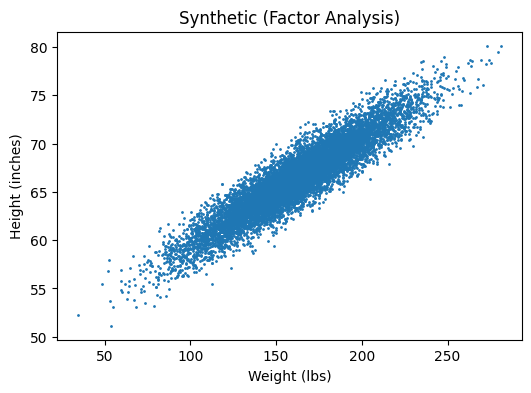

In [927]:
n_samples = 10000

samples = sample_fa(W, Psi, mu, n_samples)

plt.figure(figsize=(6,4))
plt.scatter(samples[:,0], samples[:,1], s=1)
plt.title("Synthetic (Factor Analysis)")
plt.xlabel("Weight (lbs)")
plt.ylabel("Height (inches)")

Factor Analysis works great for any data that can be well-approximated by a single multivariate Gaussian distribution, where the correlations between dimensions are driven by a smaller number of hidden factors. 

Let's take at another dataset (still height and weight, but drawn from a different population).

Text(0, 0.5, 'Height (inches)')

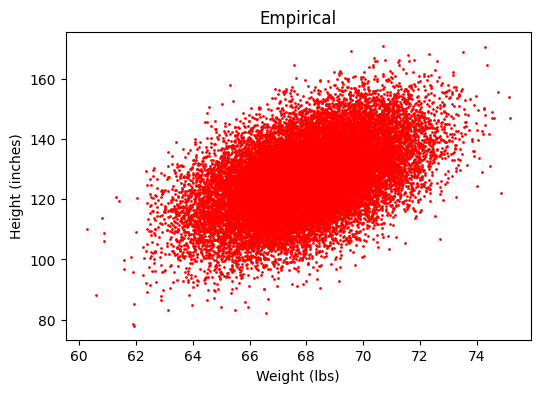

In [928]:
data = pd.read_csv("./datasets/SOCR-HeightWeight.csv")
X = np.array(data[["Height(Inches)", "Weight(Pounds)"]])

plt.figure(figsize=(6,4))
plt.scatter(X[:,0], X[:,1], s=1, c="red")
plt.title("Empirical")
plt.xlabel("Weight (lbs)")
plt.ylabel("Height (inches)")

Text(0, 0.5, 'Height (inches)')

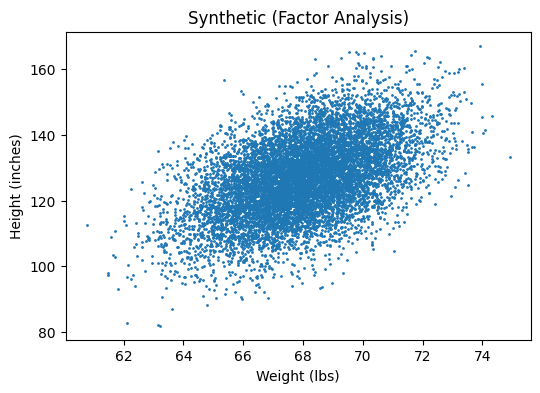

In [929]:
W, Psi, mu = fit_fa(X, 1)
n_samples=10000
samples = sample_fa(W, Psi, mu, n_samples)

plt.figure(figsize=(6,4))
plt.scatter(samples[:,0], samples[:,1], s=1)
plt.title("Synthetic (Factor Analysis)")
plt.xlabel("Weight (lbs)")
plt.ylabel("Height (inches)")

Now let's try something different. We'll generate a toy dataset and see how well our model performs on that. 

The data is distributed non-linearly (i.e., it can't be represented as a single Gaussian cloud).

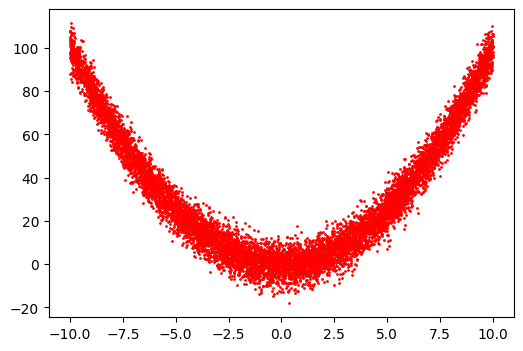

In [930]:
n_samples
x = rng.uniform(-10, 10, n_samples)
y = x ** 2 + rng.normal(0, 5, n_samples)
X = np.vstack([x,y]).T

plt.figure(figsize=(6,4))
plt.scatter(X[:,0], X[:,1], s=1, c="red")

So if we try to fit it using Factor Analysis ... 

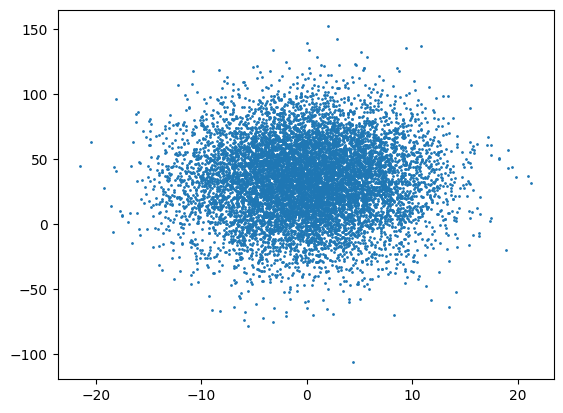

In [931]:
W, Psi, mu = fit_fa(X, 1)
samples = sample_fa(W, Psi, mu, n_samples)

plt.scatter(samples[:,0], samples[:,1], s=1)

This is because Factor Analysis constrains the data to be generated by a linear transformation of Gaussian latent factors plus noise ($x=\mu+Wz+\epsilon$), which always produces an elliptical Gaussian cloud. It can't bend to follow non-linear structure, no matter how many underlying factors we introduce.

## Conclusion
This concludes the **Factor Analysis** notebook. While effective at modelling data that is approximately Gaussian with linear combinations driven by a small number of hidden factors, FA is fundamentally limited and can only capture elliptical Gaussian blobs. If the true data lies on a more complex manifold, FA flattens this structure into a single Gaussian cloud, losing essential information. 

These limitations motivate the introduction of **non-linear generative models**, which replace the rigid linear mappings (i.e., $Wz$) with non-linear transformations. In the next notebook, we will examine **Variational Autoencoders (VAEs)**, a non-linear generalisation of FA that can warp a simple latent Gaussian into much more complex data distributions.
